In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
36134,NaN,NaN,International,2020-03-01,705.0,0.0,6.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36135,NaN,NaN,International,2020-03-02,705.0,0.0,6.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36136,NaN,NaN,International,2020-03-10,696.0,-9.0,7.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


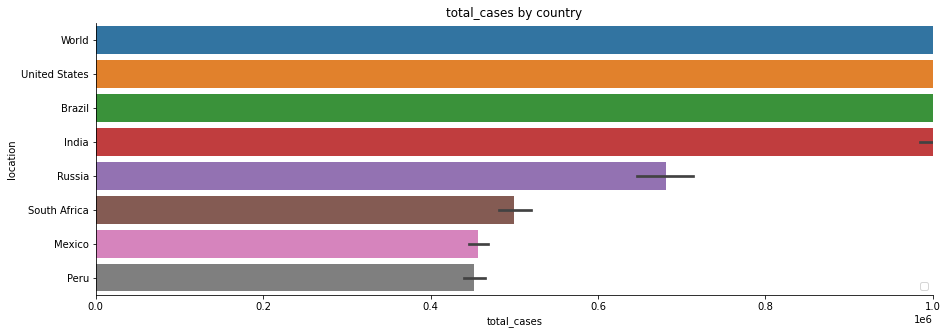

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


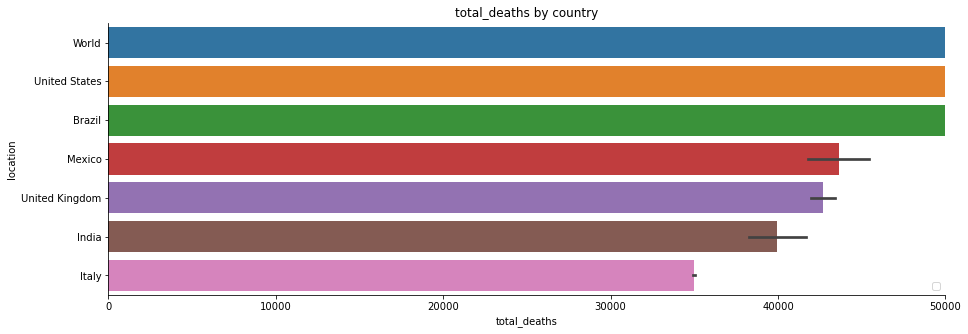

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


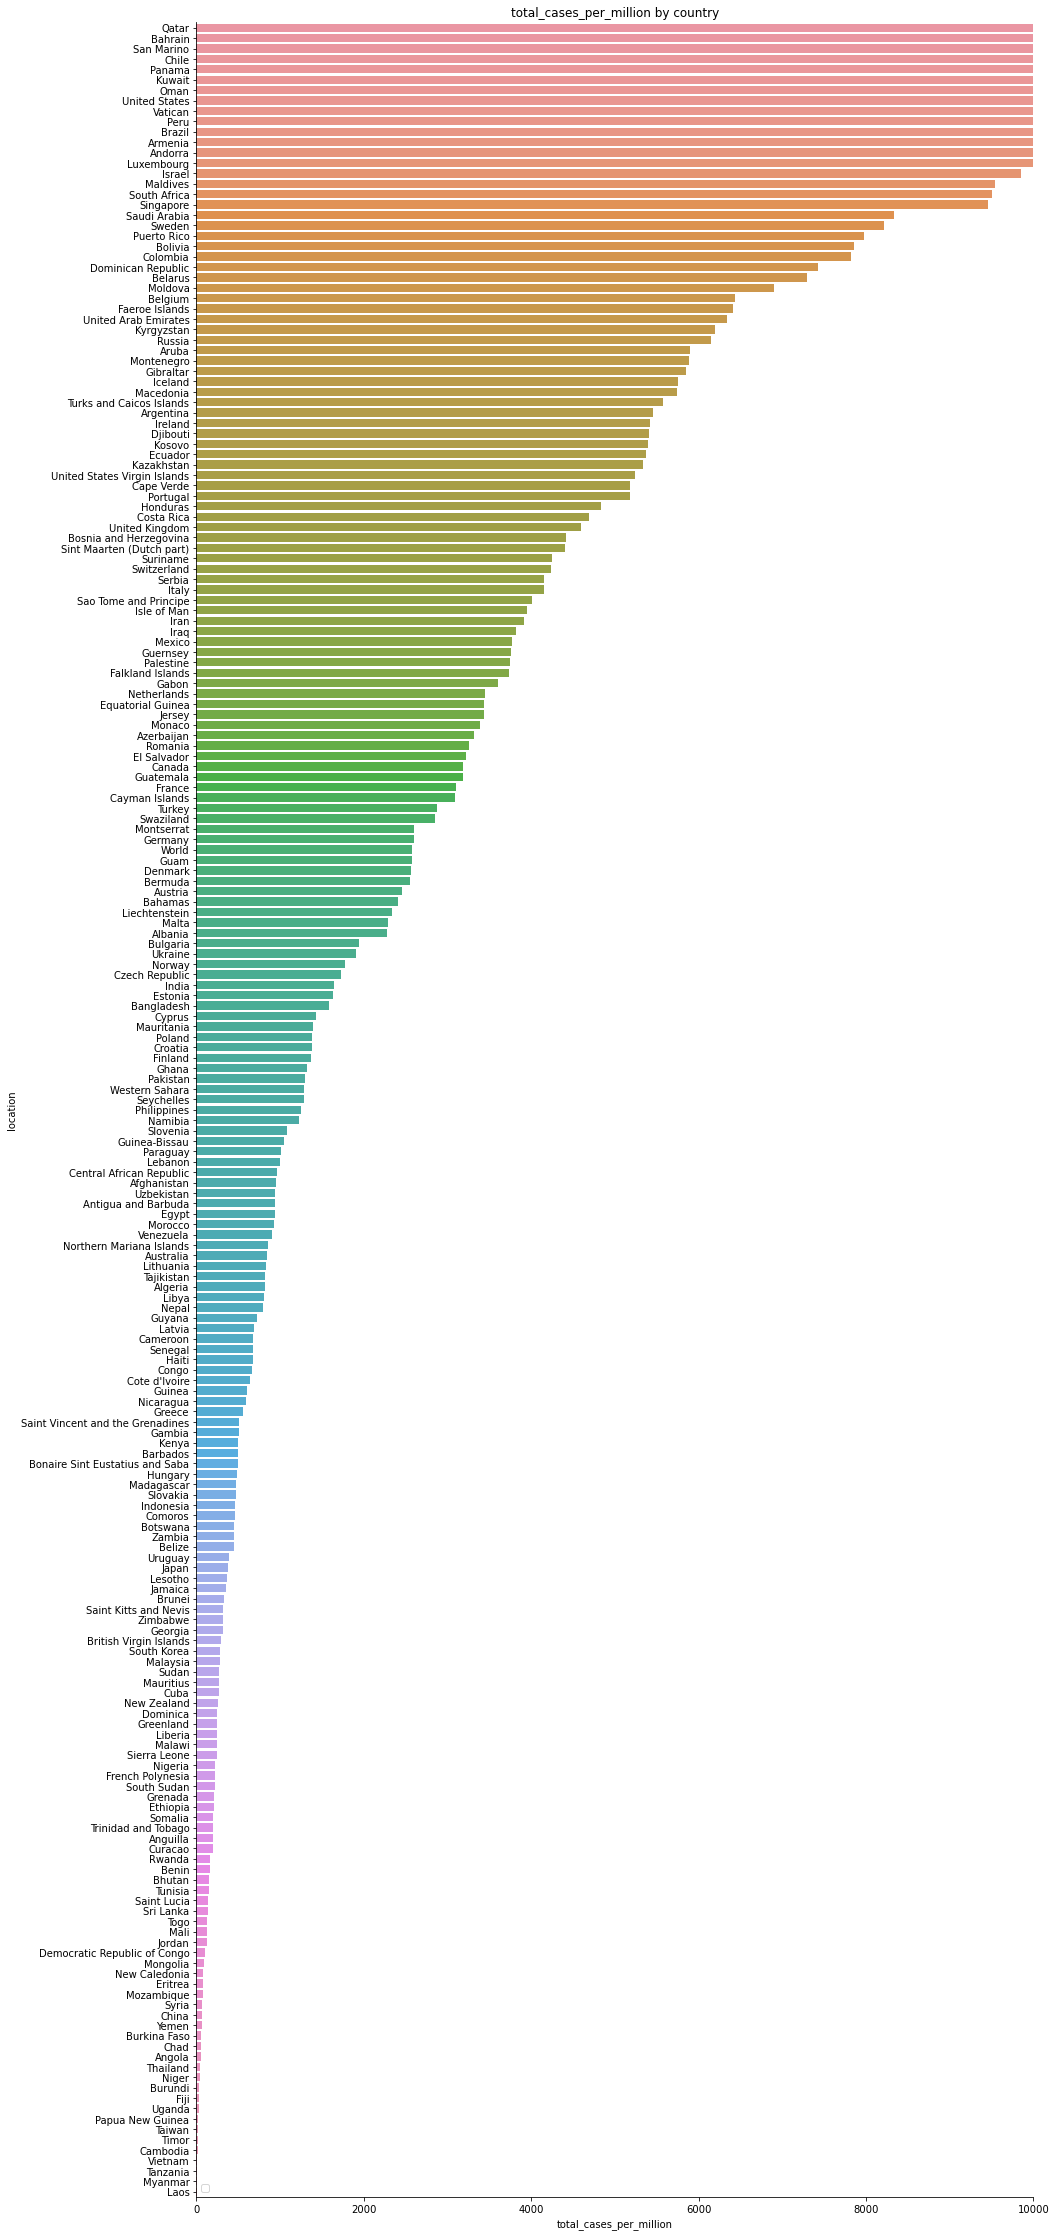

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


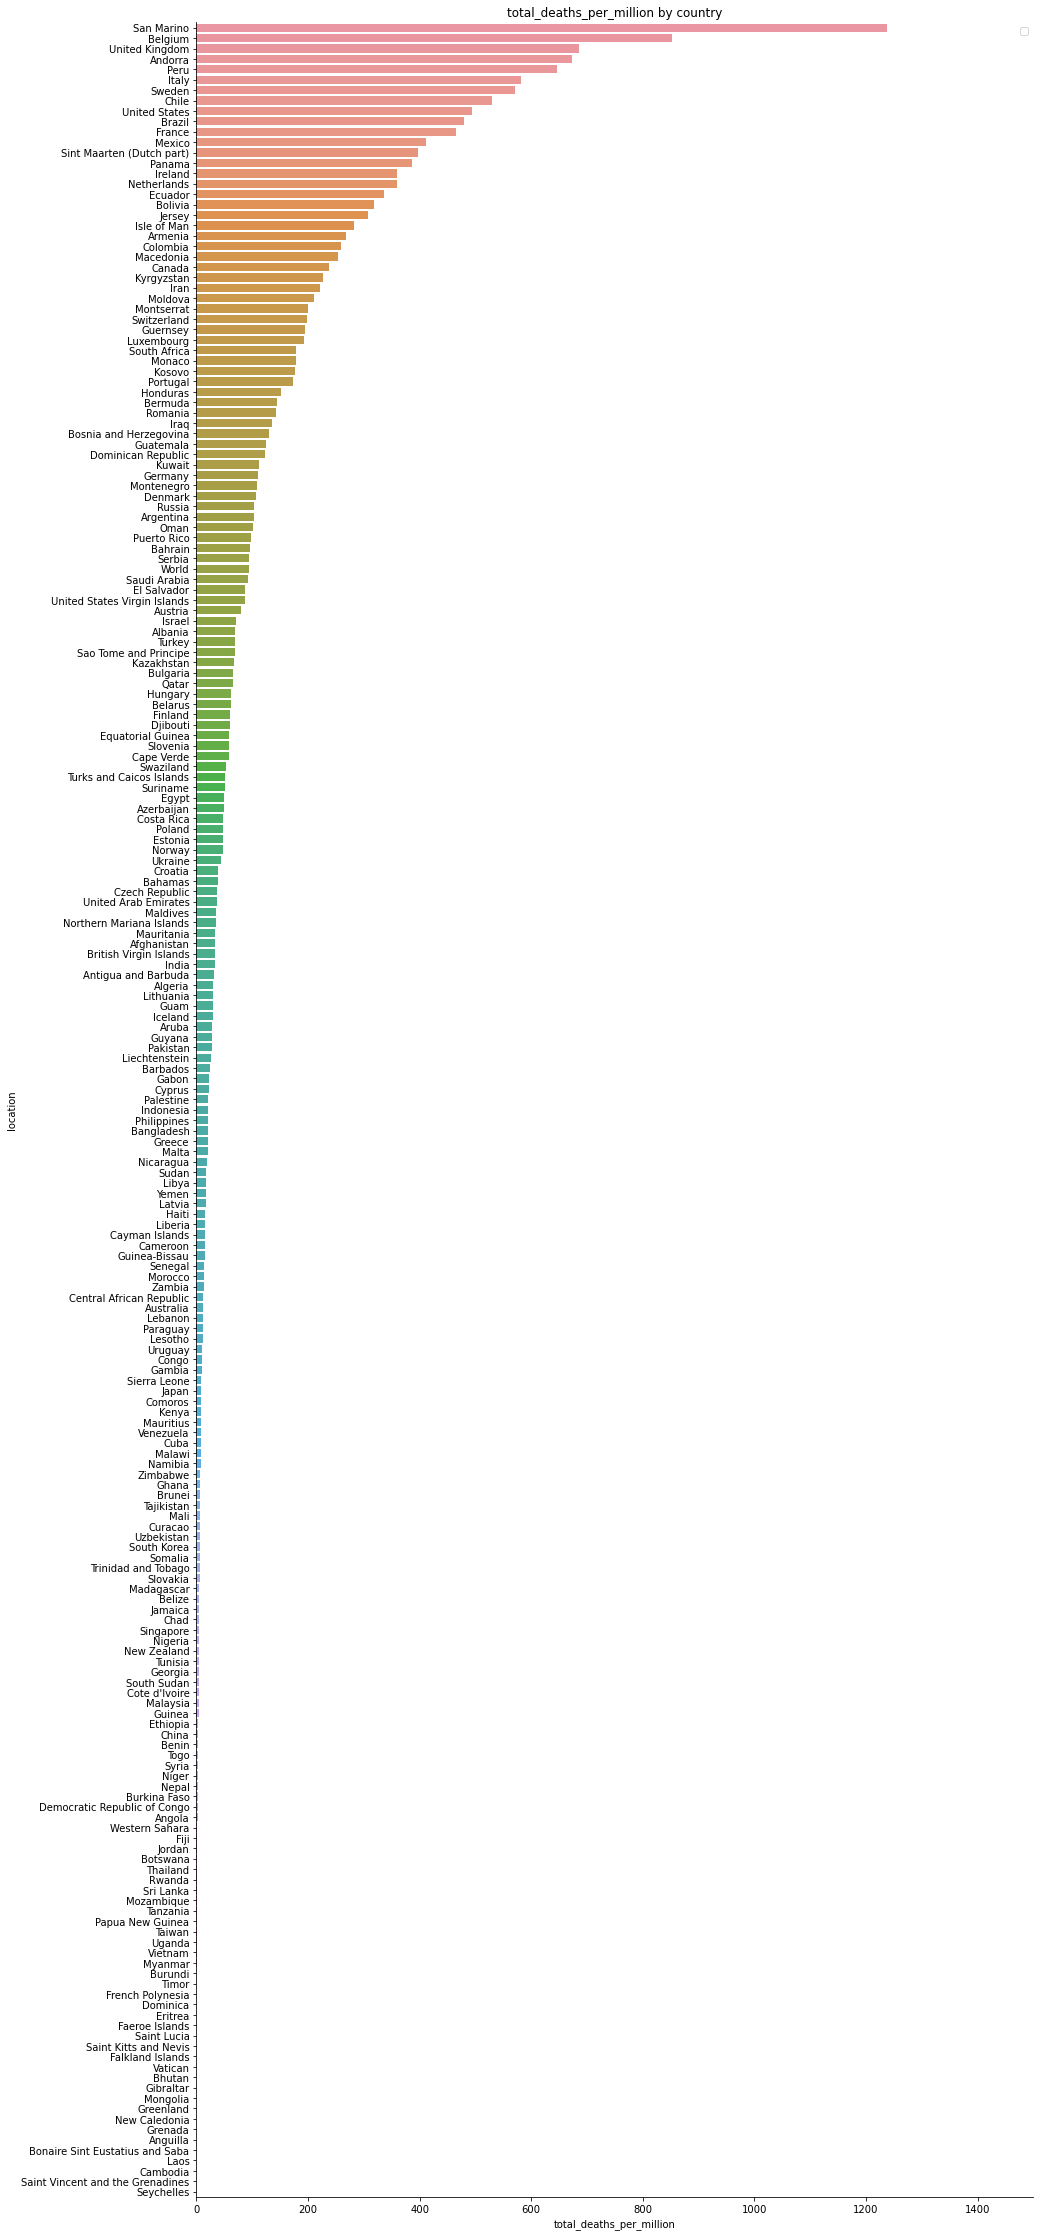

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

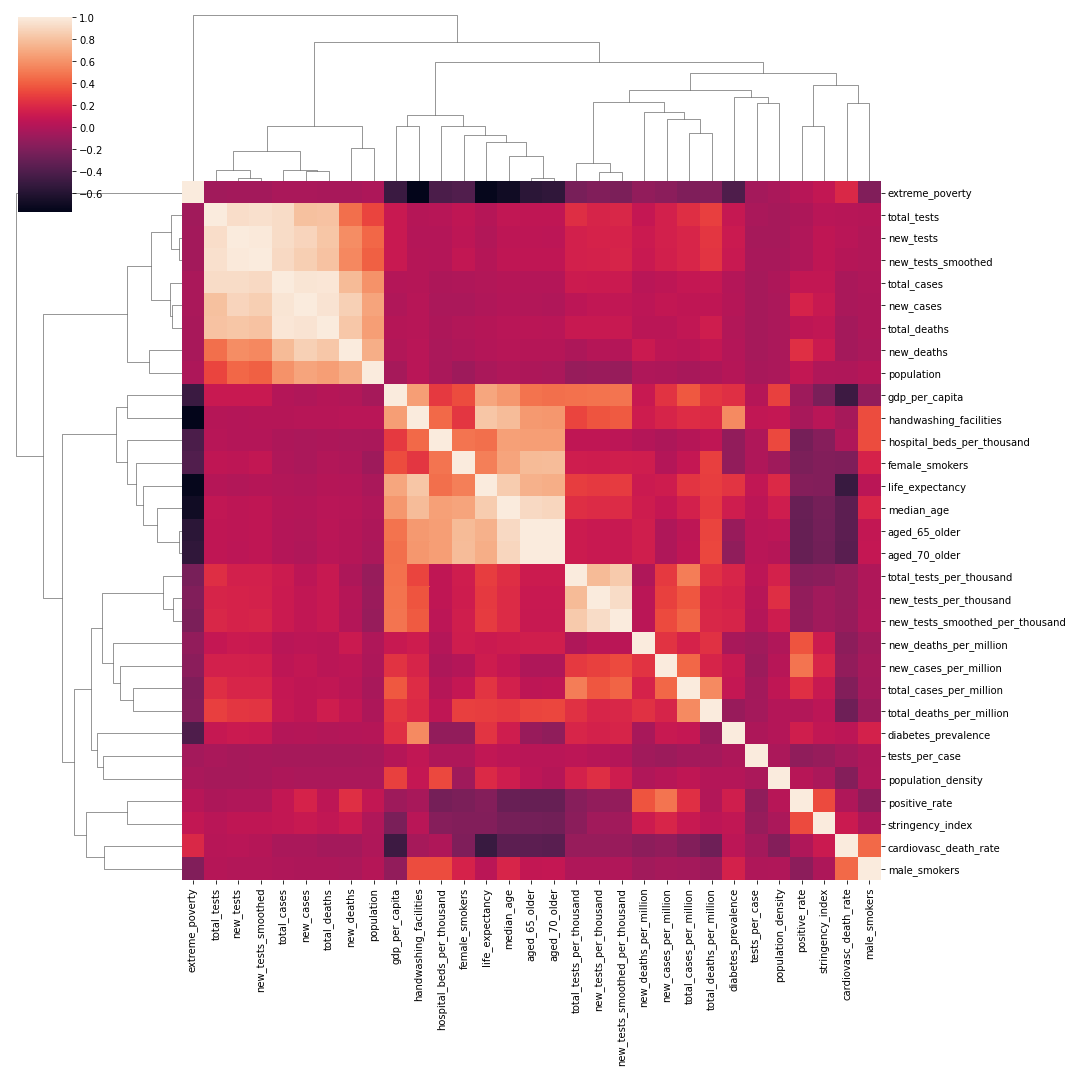

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9996531980481266 (+/- 0.00024067025228594792)
Coef :  [1.04489839e+00 8.05673664e-05 8.78092520e-05]
3 Last_days :  [[19625682 19854874 20075600]]
Today :  20075600
Prediction + :  495187
Tomorow :  20570787
                                     
--------- Total Death -----------------
                                     
R^2: 0.999564323528252 (+/- 3.805213186295099e-05)
Coef :  [-0.16035086  0.56431071  0.60532748]
3 Last_days :  [[726842 731330 736372]]
Today :  736372
Prediction + :  7456
Tomorow :  743828
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9875905794087978 (+/- 0.0055328139546133165)
Coef :  [-0.67804109  0.74364601  0.93485752]
3 Last_days :  [[197921 197921 202775]]
Today :  202775
Prediction + :  101
Tomorow :  202876
                                     
--------- Total Death -----------------
                                     
R^2: 0.43806711097060513 (+/- 0.7715311481565351)
Coef :  [-0.75698483  0.7880438   0.96811236]
3 Last_days :  [[30324 30324 30340]]
Today :  30340
Prediction + :  24
Tomorow :  30364
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.670343688111204 (+/- 0.267857009371839)
Coef :  [-0.31985989 -0.02846651  1.34259824]
3 Last_days :  [[88672 88793 88906]]
Today :  88906
Prediction + :  97
Tomorow :  89003
                                     
--------- Total Death -----------------
                                     
R^2: -1508.6289273707725 (+/- 2134.345023539454)
Coef :  [-0.07637836  0.01240647  1.0560973 ]
3 Last_days :  [[4681 4686 4690]]
Today :  4690
Prediction + :  7
Tomorow :  4697
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6362107868130019 (+/- 0.5123073500737337)
Coef :  [-0.84192998  0.90714243  0.93400186]
3 Last_days :  [[250103 250566 250825]]
Today :  250825
Prediction + :  536
Tomorow :  251361
                                     
--------- Total Death -----------------
                                     
R^2: 0.9629454140188164 (+/- 0.036415863652338)
Coef :  [-0.83986227  0.90558706  0.9335185 ]
3 Last_days :  [[35203 35205 35209]]
Today :  35209
Prediction + :  24
Tomorow :  35233
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9826367568564295 (+/- 0.011290316194768649)
Coef :  [-0.75944304  0.79992559  0.95968619]
3 Last_days :  [[314362 314362 322980]]
Today :  322980
Prediction + :  120
Tomorow :  323100
                                     
--------- Total Death -----------------
                                     
R^2: 0.14446255318911527 (+/- 0.7407785208565831)
Coef :  [-0.71258191  0.59874429  1.11287586]
3 Last_days :  [[28503 28503 28576]]
Today :  28576
Prediction + :  18
Tomorow :  28594
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.996241793780845 (+/- 0.004960011189066211)
Coef :  [0.07060939 0.46822525 0.48256336]
3 Last_days :  [[4998017 5044864 5094394]]
Today :  5094394
Prediction + :  88282
Tomorow :  5182676
                                     
--------- Total Death -----------------
                                     
R^2: 0.5060298396780026 (+/- 0.6959170870014234)
Coef :  [-0.67857375  0.78773456  0.8926211 ]
3 Last_days :  [[162425 162938 163461]]
Today :  163461
Prediction + :  798
Tomorow :  164259
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9989751861494307 (+/- 0.00039456818119578053)
Coef :  [-0.79120742  0.88163288  0.9096726 ]
3 Last_days :  [[309763 310825 311641]]
Today :  311641
Prediction + :  1210
Tomorow :  312851
                                     
--------- Total Death -----------------
                                     
R^2: 0.4783807539822706 (+/- 0.7313187084238054)
Coef :  [-0.76488882  0.83046819  0.93430603]
3 Last_days :  [[46566 46574 46526]]
Today :  46526
Prediction + :  69
Tomorow :  46595
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9923690424473106 (+/- 0.008968738622131609)
Coef :  [-0.81991516  0.86991814  0.94946172]
3 Last_days :  [[215891 216327 217293]]
Today :  217293
Prediction + :  479
Tomorow :  217772
                                     
--------- Total Death -----------------
                                     
R^2: 0.4659897885769748 (+/- 0.7376704731915196)
Coef :  [-0.80026915  0.84329469  0.9564317 ]
3 Last_days :  [[9196 9197 9201]]
Today :  9201
Prediction + :  8
Tomorow :  9209
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.38571960052939236 (+/- 0.86834733328315)
Coef :  [0.11475523 0.44891379 0.449584  ]
3 Last_days :  [[324692 326712 328844]]
Today :  328844
Prediction + :  4006
Tomorow :  332850
                                     
--------- Total Death -----------------
                                     
R^2: 0.9089596725405978 (+/- 0.12837997432566917)
Coef :  [-0.13408476  0.57577892  0.57181807]
3 Last_days :  [[18264 18427 18616]]
Today :  18616
Prediction + :  223
Tomorow :  18839
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9996349495704501 (+/- 0.00026727786938829303)
Coef :  [-0.77145021  0.86368699  0.90491519]
3 Last_days :  [[239622 240804 241997]]
Today :  241997
Prediction + :  1051
Tomorow :  243048
                                     
--------- Total Death -----------------
                                     
R^2: 0.999693264804483 (+/- 0.00015634294210224505)
Coef :  [-0.83114923  0.90457483  0.92358634]
3 Last_days :  [[5829 5844 5858]]
Today :  5858
Prediction + :  14
Tomorow :  5872
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.47741697122842974 (+/- 0.7374158563929242)
Coef :  [-0.21010679  0.47832498  0.75034694]
3 Last_days :  [[3012412 3035422 3057470]]
Today :  3057470
Prediction + :  59769
Tomorow :  3117239
                                     
--------- Total Death -----------------
                                     
R^2: 0.5189309965131352 (+/- 0.6789306829718242)
Coef :  [-0.26336839  0.57110121  0.70517193]
3 Last_days :  [[100477 101049 101752]]
Today :  101752
Prediction + :  1425
Tomorow :  103177
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(20075600, 736372, 20570787, 743828),
 (202775, 30340, 202876, 30364),
 (250825, 35209, 251361, 35233),
 (322980, 28576, 323100, 28594),
 (5094394, 163461, 5182676, 164259),
 (88906, 4690, 89003, 4697),
 (311641, 46526, 312851, 46595),
 (217293, 9201, 217772, 9209),
 (328844, 18616, 332850, 18839),
 (241997, 5858, 243048, 5872),
 (3057470, 101752, 3117239, 103177)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-11,France,202876.0,0.0,30364.0,0.0,0.0,0.0
0,2020-08-11,China,89003.0,0.0,4697.0,0.0,0.0,0.0
0,2020-08-11,Italy,251361.0,0.0,35233.0,0.0,0.0,0.0
0,2020-08-11,Spain,323100.0,0.0,28594.0,0.0,0.0,0.0
0,2020-08-11,United States,5182676.0,0.0,164259.0,0.0,0.0,0.0
0,2020-08-11,World,20570787.0,0.0,743828.0,0.0,0.0,0.0
0,2020-08-11,United Kingdom,312851.0,0.0,46595.0,0.0,0.0,0.0
0,2020-08-11,Germany,217772.0,0.0,9209.0,0.0,0.0,0.0
0,2020-08-11,Iran,332850.0,0.0,18839.0,0.0,0.0,0.0
0,2020-08-11,Turkey,243048.0,0.0,5872.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")